Next, use the two log files to determine time intervals (hours) when the scheduler was unresponsive. Do this by looking for records that are the "sbatch" command from user 9204 that have return code 1 and an execution time of ~20 seconds (at least more than 15). These are commands where the scheduler timed out in responding.

3. Calculate some descriptive statistics about how often the scheduler was unresponsive, how long these periods of time were, and create a time series plot of when the scheduler was having difficulties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Read in both slurm files and concatenate, saving together.
files = ['data/slurm_wrapper_ce6.log', 'data/slurm_wrapper_ce5.log']

for index, value in enumerate(files):
    df = (
        pd.read_csv('data/slurm_wrapper_ce6.log', 
                    sep = ' - ',
                    names = ['Timestamp',
                             'User',
                             'Retry Attempt',
                             'Execution Time',
                             'Returncode',
                             'Command'],
                    engine = 'python'))
    df['Execution Time'] = (
    df['Execution Time'].replace('time ', '', regex = True).astype('float64')
)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
    df['Unresponsive'] = (
        np.where((df['User'] == 'user 9204')\
                 & (df['Returncode'] == 'returncode 1')\
                 & (df['Command'].str.contains('sbatch'))\
                 & (df['Execution Time'] > 15), 
                 True,
                 False)
)
    df['Testing'] = (
        np.where((df['User'] == 'user 9204')\
                 & (df['Command'].str.contains('sbatch')), 
                 True,
                 False)
)
    if index == 0:
        all_dfs = df
    else:
        all_dfs = pd.concat(objs = [all_dfs, df], axis = 0)
all_dfs = all_dfs.set_index('Timestamp').sort_index(axis = 0, kind = 'mergesort')

In [12]:
# Calculate overall percentage of the time when the scheduler was unresponsive upon a test.
unresponsive_series = all_dfs['Unresponsive'].loc[all_dfs['Unresponsive'] == True]
testing_series = all_dfs['Testing'].loc[all_dfs['Testing'] == True]
overall_unresponsive_percent = round(len(unresponsive_series)/len(testing_series),9)
print("Scheduler was unresponsive for {:.3%} of all tests.".format(overall_unresponsive_percent))

Scheduler was unresponsive for 4.815% of all tests.


In [31]:
# Group data by sum of unresponsive counts per hour.
relevant_columns = ['Testing', 'Unresponsive']

for index, value in enumerate(relevant_columns):
    df = (
        all_dfs.groupby(pd.Grouper(freq = 'H'))[value].\
        sum().\
        reset_index().\
        rename(columns = {'sum':f'{value}'}))
    if index == 0:
        concat_dfs = df
    else:
        concat_dfs = concat_dfs.merge(df, on = 'Timestamp')
        
# Determine unresponsive proportion of testing results.
concat_dfs['Unresponsive_Proportion'] = (
    concat_dfs['Unresponsive']/concat_dfs['Testing']*100
)

In [69]:
# Resample responsiveness counts by day, week and month.
responsiveness_by_day = (
    pd.DataFrame(concat_dfs.resample('D', on = 'Timestamp').Unresponsive.sum())
)
responsiveness_by_week = (
    pd.DataFrame(concat_dfs.resample('W', on = 'Timestamp').Unresponsive.sum())
)
responsiveness_by_month = (
    pd.DataFrame(concat_dfs.resample('M', on = 'Timestamp').Unresponsive.sum())
)

list_of_dfs = [responsiveness_by_day, 
               responsiveness_by_week, 
               responsiveness_by_month]

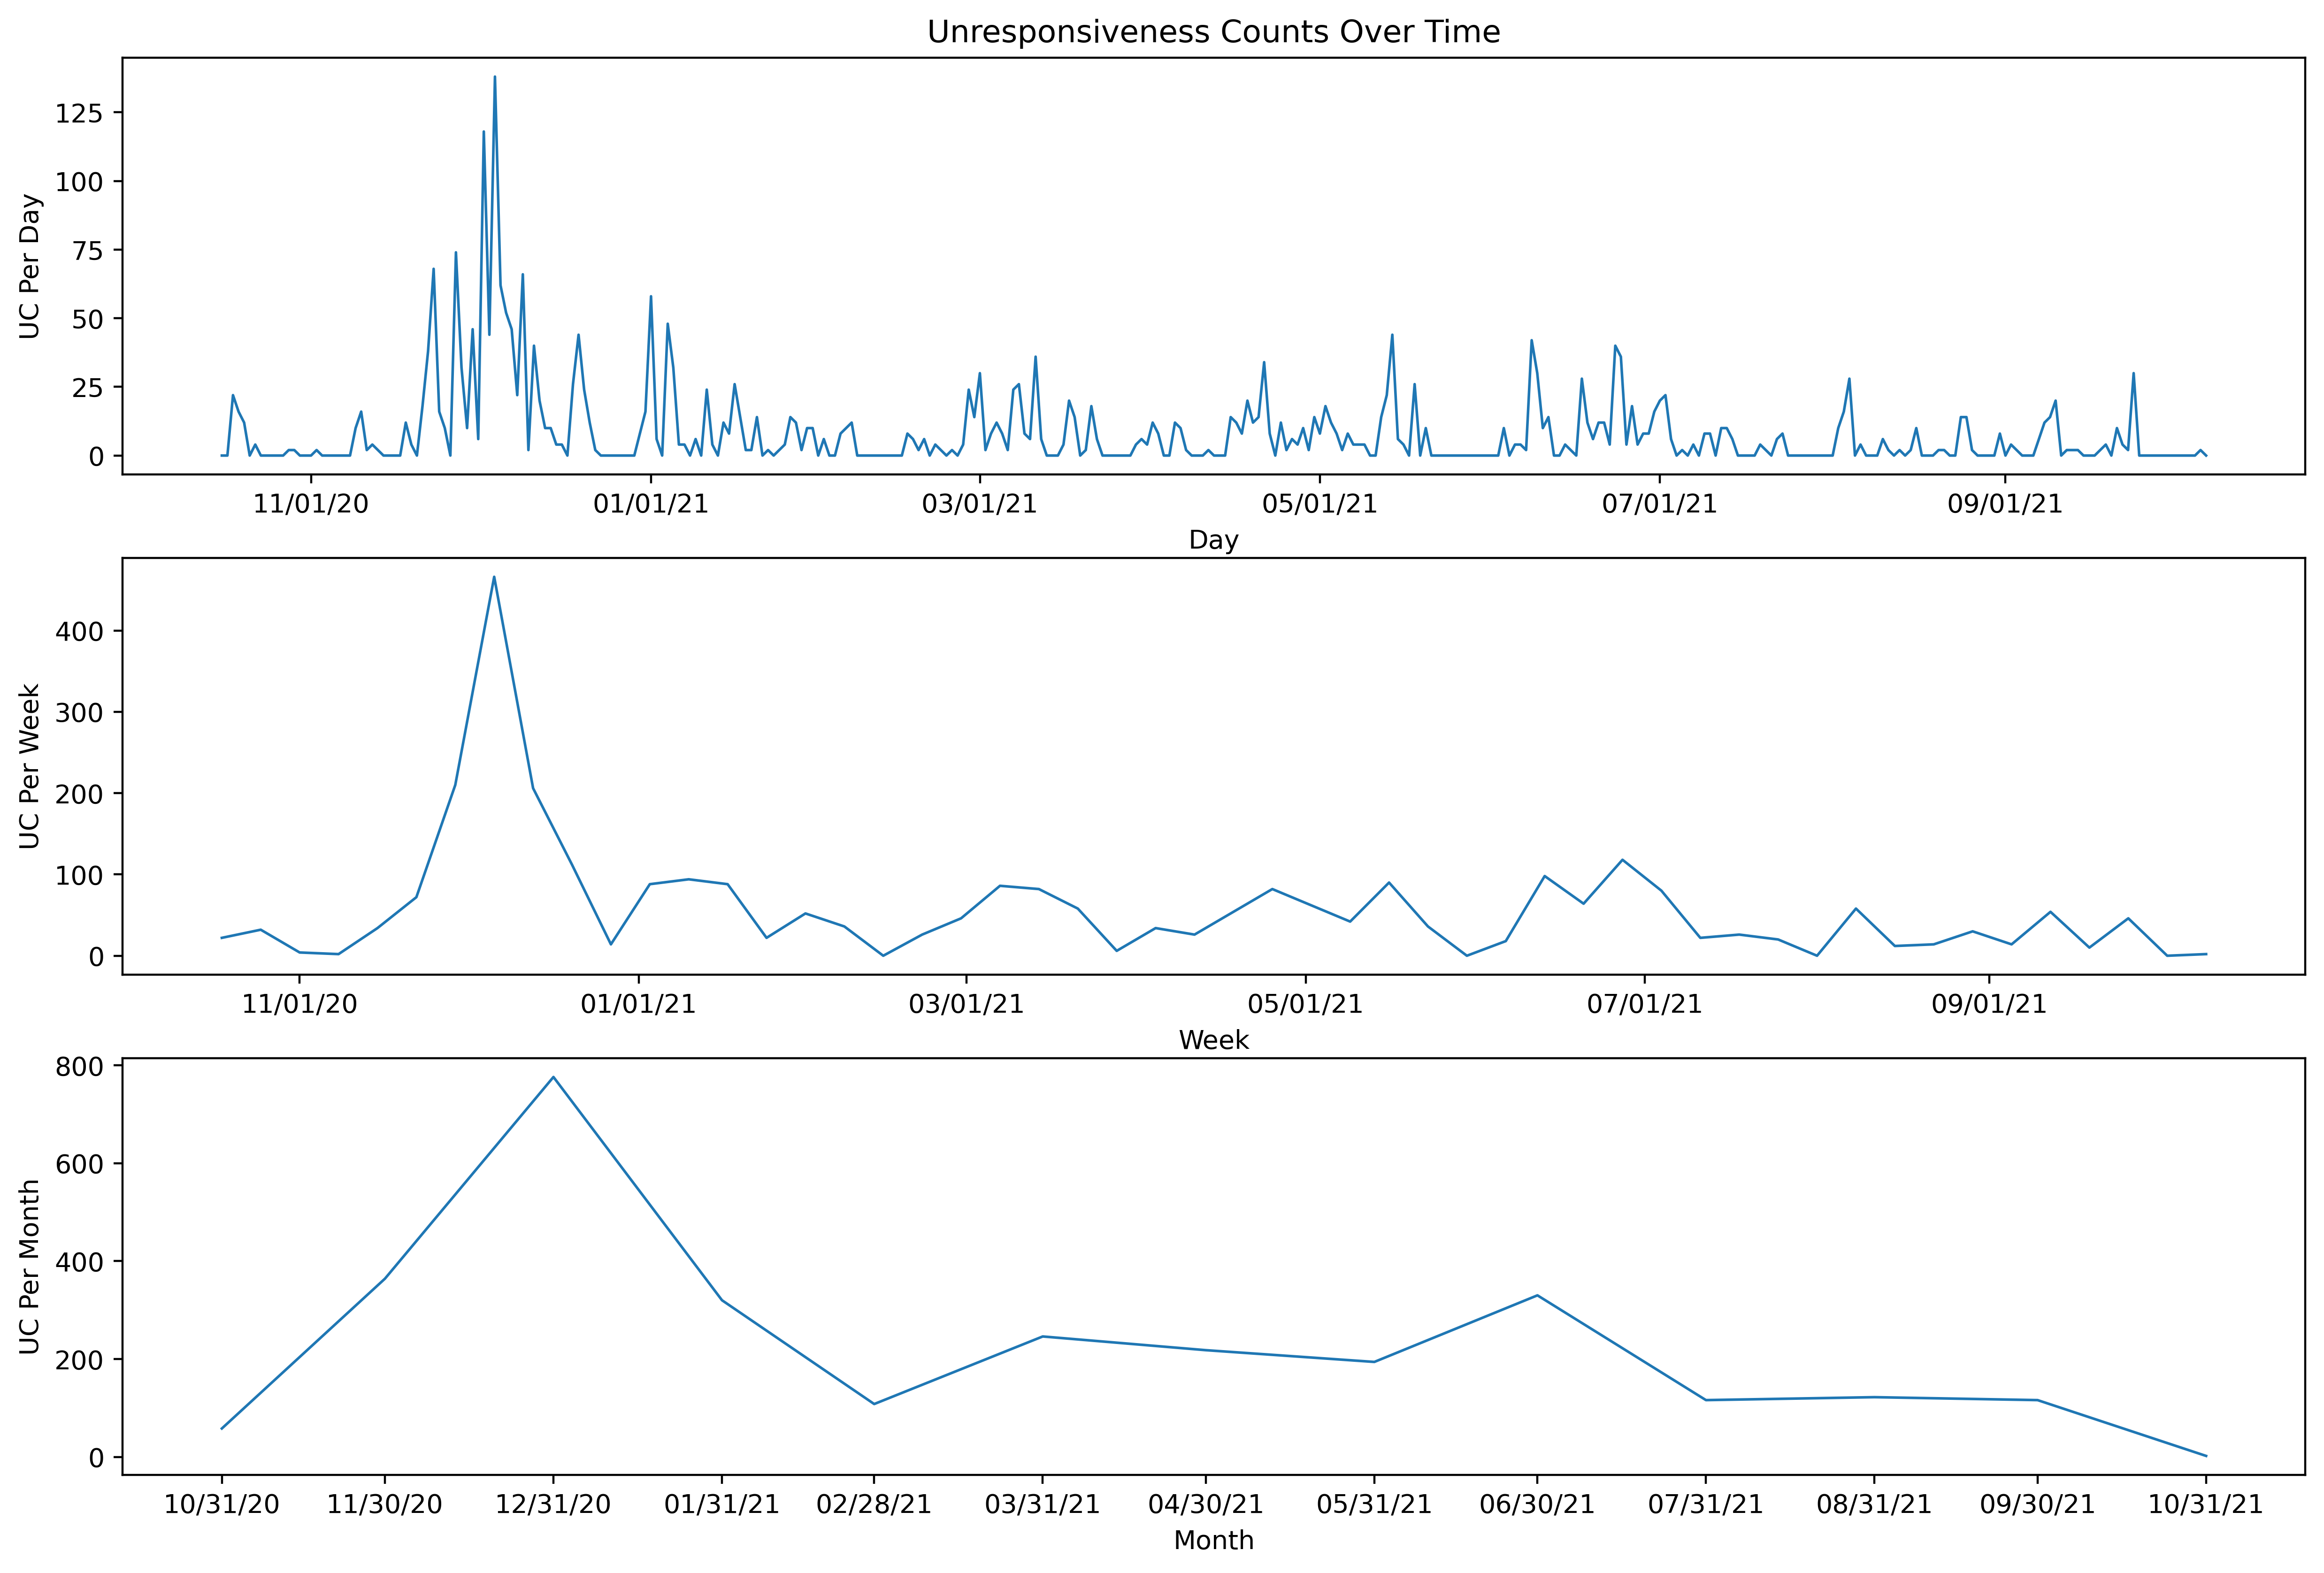

In [82]:
# Plot line graphs of unresponsive counts over time.
facecolor = 'white'
fig = plt.figure(figsize = (15, 10), dpi = 400)
axes = fig.subplots(nrows = 3)

for index, var in enumerate(list_of_dfs):
    y = var.Unresponsive
    x = var.index
    axes[index].plot(x, y, linewidth = 1)
    axes[index].xaxis.set_major_formatter(mdates.DateFormatter('%D'))
    # Address xticks.
    if index == 2:
        axes[index].set_xticks(responsiveness_by_month.index)

axes[0].set_xlabel('Day')
axes[1].set_xlabel('Week')
axes[2].set_xlabel('Month')

axes[0].set_ylabel('UC Per Day')
axes[1].set_ylabel('UC Per Week')
axes[2].set_ylabel('UC Per Month')

axes[0].set_title('Unresponsiveness Counts Over Time');

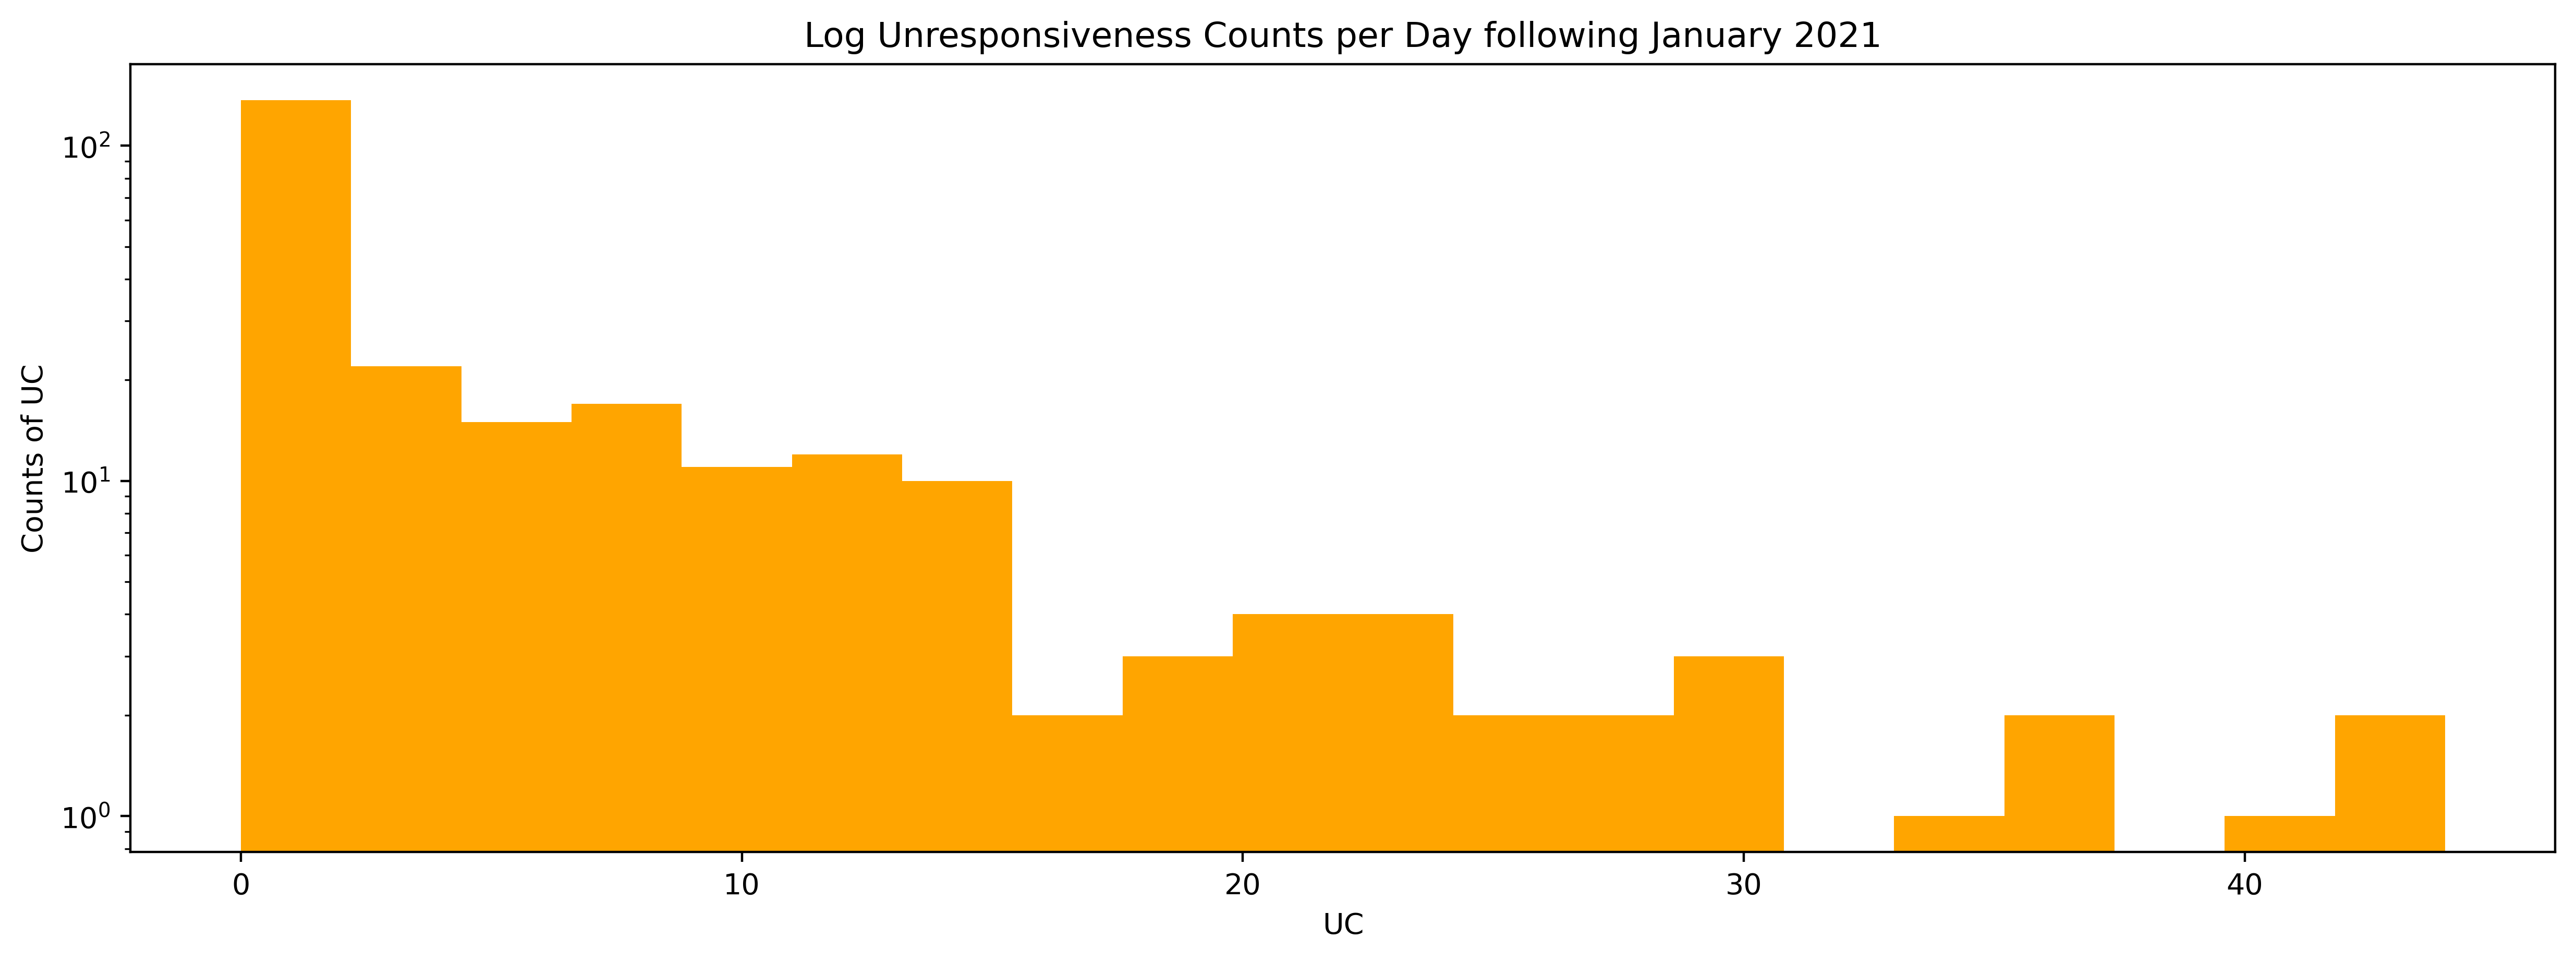

In [105]:
# Plot histgram of the unresponsive counts per day for December through January.
facecolor = 'white'
fig = plt.figure(figsize = (15, 5), dpi = 400)

x = responsiveness_by_day.Unresponsive[responsiveness_by_day.index >= '2021-01-31']
plt.hist(x, 
         bins = 20, 
         color = 'orange', 
         log = True)
plt.xlabel('UC')
plt.ylabel('Counts of UC')
plt.title('Log Unresponsiveness Counts per Day following January 2021');